In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gym

EP_MAX = 1000
EP_LEN = 200
GAMMA = 0.9
A_LR = 0.0001
C_LR = 0.0002
BATCH = 32
A_UPDATE_STEPS = 10
C_UPDATE_STEPS = 10
S_DIM, A_DIM = 3, 1
METHOD = dict(name='kl_pen', kl_target=0.01, lam=0.5)

In [10]:
class PPO(object):

    def __init__(self):
        self.sess = tf.Session()
        self.tfs = tf.placeholder(tf.float32, [None, S_DIM], 'state')

        # critic
        with tf.variable_scope('critic'):
            l1 = tf.layers.dense(self.tfs, 100, tf.nn.relu)
            self.v = tf.layers.dense(l1, 1)
            self.tfdc_r = tf.placeholder(tf.float32, [None, 1], 'discounted_r')
            self.advantage = self.tfdc_r - self.v
            self.closs = tf.reduce_mean(tf.square(self.advantage))
            self.ctrain_op = tf.train.AdamOptimizer(C_LR).minimize(self.closs)

        # actor
        pi, pi_params = self._build_anet('pi', trainable=True)
        oldpi, oldpi_params = self._build_anet('oldpi', trainable=False)
        with tf.variable_scope('sample_action'):
            self.sample_op = tf.squeeze(pi.sample(1), axis=0)       # choosing action
        with tf.variable_scope('update_oldpi'):
            self.update_oldpi_op = [oldp.assign(p) for p, oldp in zip(pi_params, oldpi_params)]

        self.tfa = tf.placeholder(tf.float32, [None, A_DIM], 'action')
        self.tfadv = tf.placeholder(tf.float32, [None, 1], 'advantage')
        with tf.variable_scope('loss'):
            with tf.variable_scope('surrogate'):
                # ratio = tf.exp(pi.log_prob(self.tfa) - oldpi.log_prob(self.tfa))
                ratio = pi.prob(self.tfa) / oldpi.prob(self.tfa)
                surr = ratio * self.tfadv
            self.tflam = tf.placeholder(tf.float32, None, 'lambda')
            kl = tf.distributions.kl_divergence(oldpi, pi)
            self.kl_mean = tf.reduce_mean(kl)
            self.aloss = -(tf.reduce_mean(surr - self.tflam * kl))
       
        with tf.variable_scope('atrain'):
            self.atrain_op = tf.train.AdamOptimizer(A_LR).minimize(self.aloss)

        tf.summary.FileWriter("log/", self.sess.graph)

        self.sess.run(tf.global_variables_initializer())

    def update(self, s, a, r):
        self.sess.run(self.update_oldpi_op)
        adv = self.sess.run(self.advantage, {self.tfs: s, self.tfdc_r: r})
        # adv = (adv - adv.mean())/(adv.std()+1e-6)     # sometimes helpful

        # update actor
        for _ in range(A_UPDATE_STEPS):
            _, kl = self.sess.run(
                [self.atrain_op, self.kl_mean],
                {self.tfs: s, self.tfa: a, self.tfadv: adv, self.tflam: METHOD['lam']})
            if kl > 4*METHOD['kl_target']:  # this in in google's paper
                break
        if kl < METHOD['kl_target'] / 1.5:  # adaptive lambda, this is in OpenAI's paper
            METHOD['lam'] /= 2
        elif kl > METHOD['kl_target'] * 1.5:
            METHOD['lam'] *= 2
        METHOD['lam'] = np.clip(METHOD['lam'], 1e-4, 10)    # sometimes explode, this clipping is my solution
   
        # update critic
        [self.sess.run(self.ctrain_op, {self.tfs: s, self.tfdc_r: r}) for _ in range(C_UPDATE_STEPS)]

    def _build_anet(self, name, trainable):
        with tf.variable_scope(name):
            l1 = tf.layers.dense(self.tfs, 100, tf.nn.relu, trainable=trainable)
            mu = 2 * tf.layers.dense(l1, A_DIM, tf.nn.tanh, trainable=trainable)
            sigma = tf.layers.dense(l1, A_DIM, tf.nn.softplus, trainable=trainable)
            norm_dist = tf.distributions.Normal(loc=mu, scale=sigma)
        params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=name)
        return norm_dist, params

    def choose_action(self, s):
        s = s[np.newaxis, :]
        a = self.sess.run(self.sample_op, {self.tfs: s})[0]
        return np.clip(a, -2, 2)

    def get_v(self, s):
        if s.ndim < 2: s = s[np.newaxis, :]
        return self.sess.run(self.v, {self.tfs: s})[0, 0]


In [12]:
tf.reset_default_graph ()
env = gym.make('Pendulum-v0').unwrapped
ppo = PPO()
all_ep_r = []

In [13]:
for ep in range(EP_MAX):
    s = env.reset()
    buffer_s, buffer_a, buffer_r = [], [], []
    ep_r = 0
    for t in range(EP_LEN):    # in one episode
        env.render()
        a = ppo.choose_action(s)
        s_, r, done, _ = env.step(a)
        buffer_s.append(s)
        buffer_a.append(a)
        buffer_r.append((r+8)/8)    # normalize reward, find to be useful
        s = s_
        ep_r += r

        # update ppo
        if (t+1) % BATCH == 0 or t == EP_LEN-1:
            v_s_ = ppo.get_v(s_)
            discounted_r = []
            for r in buffer_r[::-1]:
                v_s_ = r + GAMMA * v_s_
                discounted_r.append(v_s_)
            discounted_r.reverse()

            bs, ba, br = np.vstack(buffer_s), np.vstack(buffer_a), np.array(discounted_r)[:, np.newaxis]
            buffer_s, buffer_a, buffer_r = [], [], []
            ppo.update(bs, ba, br)
    if ep == 0: all_ep_r.append(ep_r)
    else: all_ep_r.append(all_ep_r[-1]*0.9 + ep_r*0.1)
    print('Ep: %i' % ep, "|Ep_r: %i" % ep_r, "|Lam: %.4f" % METHOD['lam'])

Ep: 0 |Ep_r: -1697 |Lam: 0.0039
Ep: 1 |Ep_r: -1480 |Lam: 0.0001
Ep: 2 |Ep_r: -1299 |Lam: 0.0016
Ep: 3 |Ep_r: -1219 |Lam: 0.0001
Ep: 4 |Ep_r: -1121 |Lam: 0.0001
Ep: 5 |Ep_r: -1628 |Lam: 0.0001
Ep: 6 |Ep_r: -1347 |Lam: 0.0001
Ep: 7 |Ep_r: -1730 |Lam: 0.0001
Ep: 8 |Ep_r: -1225 |Lam: 0.0001
Ep: 9 |Ep_r: -1458 |Lam: 0.0001
Ep: 10 |Ep_r: -1520 |Lam: 0.0001
Ep: 11 |Ep_r: -1281 |Lam: 0.0002
Ep: 12 |Ep_r: -1195 |Lam: 0.0008
Ep: 13 |Ep_r: -1406 |Lam: 0.0001
Ep: 14 |Ep_r: -1598 |Lam: 0.0001
Ep: 15 |Ep_r: -973 |Lam: 0.0008
Ep: 16 |Ep_r: -1357 |Lam: 0.0001
Ep: 17 |Ep_r: -1106 |Lam: 0.0001
Ep: 18 |Ep_r: -1057 |Lam: 0.0001
Ep: 19 |Ep_r: -887 |Lam: 0.0001
Ep: 20 |Ep_r: -1337 |Lam: 0.0001
Ep: 21 |Ep_r: -1023 |Lam: 0.0002
Ep: 22 |Ep_r: -1273 |Lam: 0.0001
Ep: 23 |Ep_r: -1342 |Lam: 0.0001
Ep: 24 |Ep_r: -906 |Lam: 0.0001
Ep: 25 |Ep_r: -1480 |Lam: 0.0001
Ep: 26 |Ep_r: -1302 |Lam: 0.0001
Ep: 27 |Ep_r: -1191 |Lam: 0.0001
Ep: 28 |Ep_r: -1048 |Lam: 0.0001
Ep: 29 |Ep_r: -1453 |Lam: 0.0001
Ep: 30 |Ep_r: -1192 |La

Ep: 246 |Ep_r: -776 |Lam: 0.0001
Ep: 247 |Ep_r: -390 |Lam: 0.0001
Ep: 248 |Ep_r: -517 |Lam: 0.0001
Ep: 249 |Ep_r: -668 |Lam: 0.0001
Ep: 250 |Ep_r: -389 |Lam: 0.0001
Ep: 251 |Ep_r: -782 |Lam: 0.0001
Ep: 252 |Ep_r: -257 |Lam: 0.0001
Ep: 253 |Ep_r: -825 |Lam: 0.0001
Ep: 254 |Ep_r: -401 |Lam: 0.0001
Ep: 255 |Ep_r: -541 |Lam: 0.0001
Ep: 256 |Ep_r: -260 |Lam: 0.0001
Ep: 257 |Ep_r: -648 |Lam: 0.0001
Ep: 258 |Ep_r: -791 |Lam: 0.0001
Ep: 259 |Ep_r: -596 |Lam: 0.0001
Ep: 260 |Ep_r: -391 |Lam: 0.0001
Ep: 261 |Ep_r: -262 |Lam: 0.0001
Ep: 262 |Ep_r: -261 |Lam: 0.0001
Ep: 263 |Ep_r: -672 |Lam: 0.0001
Ep: 264 |Ep_r: -765 |Lam: 0.0001
Ep: 265 |Ep_r: -1071 |Lam: 0.0016
Ep: 266 |Ep_r: -547 |Lam: 0.0002
Ep: 267 |Ep_r: -680 |Lam: 0.0001
Ep: 268 |Ep_r: -826 |Lam: 0.0001
Ep: 269 |Ep_r: -809 |Lam: 0.0001
Ep: 270 |Ep_r: -393 |Lam: 0.0001
Ep: 271 |Ep_r: -402 |Lam: 0.0001
Ep: 272 |Ep_r: -520 |Lam: 0.0001
Ep: 273 |Ep_r: -651 |Lam: 0.0001
Ep: 274 |Ep_r: -811 |Lam: 0.0001
Ep: 275 |Ep_r: -533 |Lam: 0.0001
Ep: 276 |

Ep: 496 |Ep_r: -1360 |Lam: 0.0064
Ep: 497 |Ep_r: -1253 |Lam: 0.0512
Ep: 498 |Ep_r: -131 |Lam: 0.0004
Ep: 499 |Ep_r: -987 |Lam: 0.0002
Ep: 500 |Ep_r: -275 |Lam: 0.0001
Ep: 501 |Ep_r: -1256 |Lam: 0.0032
Ep: 502 |Ep_r: -930 |Lam: 0.0008
Ep: 503 |Ep_r: -500 |Lam: 0.0001
Ep: 504 |Ep_r: -5 |Lam: 0.0001
Ep: 505 |Ep_r: -800 |Lam: 0.0002
Ep: 506 |Ep_r: -1248 |Lam: 0.0064
Ep: 507 |Ep_r: -2 |Lam: 0.0001
Ep: 508 |Ep_r: -1242 |Lam: 0.0128
Ep: 509 |Ep_r: -944 |Lam: 0.1024
Ep: 510 |Ep_r: -1005 |Lam: 1.6384
Ep: 511 |Ep_r: -1142 |Lam: 10.0000
Ep: 512 |Ep_r: -443 |Lam: 0.3125
Ep: 513 |Ep_r: -2 |Lam: 0.0024
Ep: 514 |Ep_r: -1246 |Lam: 0.0049
Ep: 515 |Ep_r: -1250 |Lam: 0.0001
Ep: 516 |Ep_r: -803 |Lam: 0.0008
Ep: 517 |Ep_r: -1274 |Lam: 0.0004
Ep: 518 |Ep_r: -1252 |Lam: 0.0001
Ep: 519 |Ep_r: -1303 |Lam: 0.0008
Ep: 520 |Ep_r: -1361 |Lam: 0.0001
Ep: 521 |Ep_r: -1350 |Lam: 0.0002
Ep: 522 |Ep_r: -1 |Lam: 0.0001
Ep: 523 |Ep_r: -132 |Lam: 0.0001
Ep: 524 |Ep_r: -1252 |Lam: 0.0001
Ep: 525 |Ep_r: -1258 |Lam: 0.0032
E

Ep: 743 |Ep_r: -1322 |Lam: 0.0016
Ep: 744 |Ep_r: -1479 |Lam: 0.1024
Ep: 745 |Ep_r: 0 |Lam: 0.0008
Ep: 746 |Ep_r: -1172 |Lam: 0.0256
Ep: 747 |Ep_r: -438 |Lam: 0.0016
Ep: 748 |Ep_r: -137 |Lam: 0.0001
Ep: 749 |Ep_r: -1367 |Lam: 0.0064
Ep: 750 |Ep_r: -1486 |Lam: 0.4096
Ep: 751 |Ep_r: -1372 |Lam: 0.1024
Ep: 752 |Ep_r: -1350 |Lam: 0.8192
Ep: 753 |Ep_r: -1462 |Lam: 0.4096
Ep: 754 |Ep_r: -1327 |Lam: 0.2048
Ep: 755 |Ep_r: -1349 |Lam: 1.6384
Ep: 756 |Ep_r: -1325 |Lam: 0.8192
Ep: 757 |Ep_r: -1370 |Lam: 0.2048
Ep: 758 |Ep_r: -1336 |Lam: 0.4096
Ep: 759 |Ep_r: -3 |Lam: 0.0032
Ep: 760 |Ep_r: -129 |Lam: 0.0001
Ep: 761 |Ep_r: -137 |Lam: 0.0001
Ep: 762 |Ep_r: -1 |Lam: 0.0001
Ep: 763 |Ep_r: -1356 |Lam: 0.0032
Ep: 764 |Ep_r: -1379 |Lam: 0.1024
Ep: 765 |Ep_r: -1264 |Lam: 0.4096
Ep: 766 |Ep_r: 0 |Lam: 0.0032
Ep: 767 |Ep_r: -135 |Lam: 0.0001
Ep: 768 |Ep_r: 0 |Lam: 0.0001
Ep: 769 |Ep_r: -134 |Lam: 0.0001
Ep: 770 |Ep_r: -1369 |Lam: 0.0032
Ep: 771 |Ep_r: -261 |Lam: 0.0001
Ep: 772 |Ep_r: -1381 |Lam: 0.0064
Ep: 7

Ep: 989 |Ep_r: -1234 |Lam: 0.0064
Ep: 990 |Ep_r: -2 |Lam: 0.0001
Ep: 991 |Ep_r: -1269 |Lam: 0.0064
Ep: 992 |Ep_r: -1272 |Lam: 0.0512
Ep: 993 |Ep_r: -1223 |Lam: 0.8192
Ep: 994 |Ep_r: -278 |Lam: 0.0064
Ep: 995 |Ep_r: -1304 |Lam: 0.0512
Ep: 996 |Ep_r: -414 |Lam: 0.0008
Ep: 997 |Ep_r: -2 |Lam: 0.0001
Ep: 998 |Ep_r: -1367 |Lam: 0.0128
Ep: 999 |Ep_r: -1389 |Lam: 0.4096


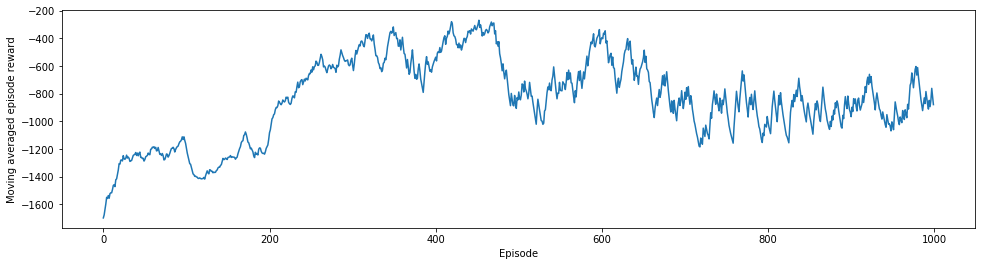

In [14]:
plt.figure(figsize=[36, 4])
plt.subplot(1, 2, 2)
plt.plot(np.arange(len(all_ep_r)), all_ep_r)
plt.xlabel('Episode')
plt.ylabel('Moving averaged episode reward')
plt.show()        